In [1]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("ipythonx/wikiart-gangogh-creating-art-gan")

print("Path to dataset files:", path)

100%|██████████| 34.6G/34.6G [05:36<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ipythonx/wikiart-gangogh-creating-art-gan/versions/2


In [28]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from PIL import ImageFile, Image
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [30]:
print(device)

cuda


In [38]:
import random
from torch.utils.data import Subset, random_split

data_dir = f"{path}/images"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# changed | for better results you can increase the sample size (10K to 20K)
indices = random.sample(range(len(dataset)), 10000) # only 10k samples used
dataset_subset = Subset(dataset, indices)


train_size = int(0.8 * len(dataset_subset))
val_size = len(dataset_subset) - train_size
train_set, val_set = random_split(dataset_subset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)

class_names = dataset.classes
print(f"Detected styles: {class_names}")

Detected styles: ['abstract', 'animal-painting', 'cityscape', 'figurative', 'flower-painting', 'genre-painting', 'landscape', 'marina', 'mythological-painting', 'nude-painting-nu', 'portrait', 'religious-painting', 'still-life', 'symbolic-painting']


In [39]:
len(train_set)

8000

In [40]:
len(val_set)

2000

In [41]:
model = models.resnet18(weights='DEFAULT') # for better results you can test resnet50
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [42]:
def train_model(epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # validate at the end
    validate()

def validate():
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu())
            y_pred.extend(preds.cpu())
    print(classification_report(y_true, y_pred, target_names=class_names))

def save_model(path='art_style_model.pth'):
    torch.save(model.state_dict(), path)
    print("Model saved!")

In [43]:
train_model(epochs=10)

Epoch [1/10], Loss: 1.2199
Epoch [2/10], Loss: 0.6247
Epoch [3/10], Loss: 0.2353
Epoch [4/10], Loss: 0.0720
Epoch [5/10], Loss: 0.0315
Epoch [6/10], Loss: 0.0168
Epoch [7/10], Loss: 0.0205
Epoch [8/10], Loss: 0.0571
Epoch [9/10], Loss: 0.1071
Epoch [10/10], Loss: 0.0602
                       precision    recall  f1-score   support

             abstract       0.76      0.84      0.80       300
      animal-painting       0.61      0.34      0.44        41
            cityscape       0.61      0.70      0.65       136
           figurative       0.26      0.22      0.24        85
      flower-painting       0.67      0.67      0.67        30
       genre-painting       0.55      0.73      0.63       332
            landscape       0.75      0.74      0.75       316
               marina       0.72      0.55      0.63        38
mythological-painting       0.47      0.16      0.23        58
     nude-painting-nu       0.80      0.50      0.61        70
             portrait       0.74   

In [44]:
from google.colab import files
from PIL import Image
import io

uploaded = files.upload()

Saving 0038c4f0f3b71bab6bf66629bcb24e74.jpg to 0038c4f0f3b71bab6bf66629bcb24e74.jpg


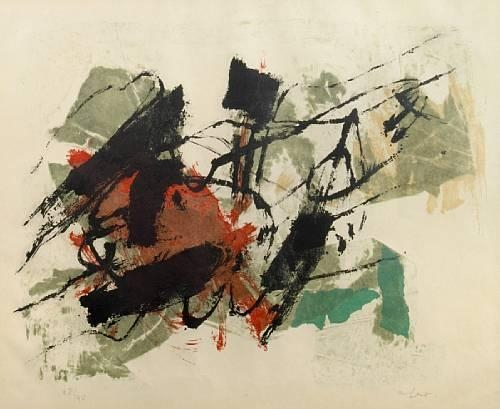

In [48]:
image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')
img

In [46]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_class = torch.max(output, 1)

predicted_style = class_names[predicted_class.item()]
print(f"Predicted Art Style: **{predicted_style}**")

Predicted Art Style: **abstract**
